## General Overview
What is a galaxy power spectrum and why do they matter? 

Creating our log-normal mock

Plotting the true power spectrum with nbodykit 

Pair-counting method

FFT P(k)

Error Analysis

Efficiency Comparison

## Introduction and Motivation


Studies of the large-scale structure of the Universe provide insight into the conditions of the early universe, the nature of dark matter and dark energy, and galaxy evolution. 
One of the most important statistical tools that cosmologists use to understand large-scale structure is the galaxy power spectrum, P(k),which quanitfies the clustering of galaxies as a function of spatial scale. 
By analyzing the shape and features of the galaxy power spectrum, cosmologists can trace the growth of structure across cosmic time and constrain key cosmological parameters. 

### Calculating P(k)
P(k) is the Fourier transform of the two-point correlation function, $\xi(r)$. 

$\xi(r)$ measures the clumpiness of galaxies by quantifying the excess probability of finding a pair of galaxies separated by a distace r, compared to a random, uniform distribution. 
\begin{align}
P(k)= \int{\xi(r)e^{i\boldsymbol{k}\cdot\boldsymbol{r}} d^3\boldsymbol{r}}
\end{align}

For our project, we will create a mock galaxy catalog and compare the accuracy and computational efficiency of different methods of calculating P(k).

## Creating a Mock Catalog

We use the Python package nbodykit to generate a log-normal mock catalog at z=0.55 with galaxy bias b=2 in a box of side-length 1380 Mpc/h. Our mock catalog contains ~8 million galaxies

Log-normal mocks assume that the matter density field follows a log-normal distribution. This ensures that the densities remain positive and mimic the midly non-linear clustering of galaxies. Galaxies are then sampled from this distribution following an input power spectrum. This will serve as our true power spectrum that we can compare our P(k) estimators to.

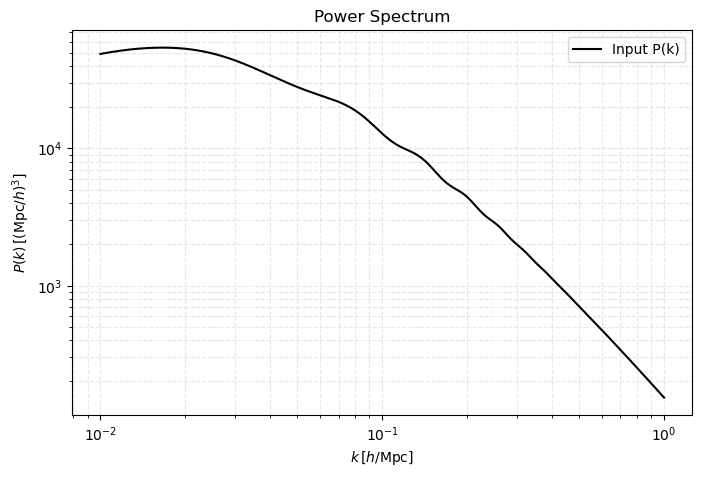

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot real P(k) from nbodykit
truth = np.loadtxt("power_spectrum.txt", skiprows=1)
k_true = truth[:, 0]
P_true = truth[:, 1]

plt.figure(figsize=[8,5])
plt.loglog(k_true, P_true, color='k', label='Input P(k)')

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [( \mathrm{Mpc}/h)^3 ]$')
plt.title('Power Spectrum')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)

### What can we learn from this power spectrum? 

Let's start with the x-axis. Small k values correspond to large physical scales (hundreds of Mpc) and large k values correspond to small scales. 

We immediately notice that the clustering amplitude is largest at large-scales and decreases as we move to smaller scales. There is a turnover point after which the power spectrum begins decreasing steeply, the location of this turnover point encodes information about the epoch of matter-radiation equality. 

There are also some small wiggles around k ~ 0.06-0.3. These are the Baryon Acoustic Oscillations (BAO) caused by acoustic density waves in the photon-baryon plasma of the early universe.

## How can we measure the power spectrum from our mock catalog? 

1. Pair-counting Method
2. Taking the Fourier transform of the galaxy overdensity field

## Method 2: Taking the Fourier Transform of the galaxy overdensity field

We begin by assigning our mock galaxies to a 3D grid so that we can FFT the field. 

We use the Cloud-in-Cell mass assignment scheme to find the total density at each grid point. In 3D, each particle contributes to the 8 neighboring grid points. The weight assigned to each point is a function of the particle's 3D position. Then density field cnan then be computed by adding up all the density contributions from all the galaxies at each grid point

In [10]:
# Load in mock catalog 
data = np.load("mock_catalog.npz")
positions = data['pos']

# Assign mock particles to a grid
def cic_grid(positions, Ngrid, boxsize):
    # Create a 3d grid
    density = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)
    # Convert physical coordinates to grid coordinates
    cell = positions / (boxsize / Ngrid)
    # Find index of the grid cell for each particle 
    i = np.floor(cell).astype(int) % Ngrid # %Ngrid wraps positions that land outside the box 
    # How far the particle is from the grid points in all 3 dimensions
    d = cell - i

    # Distribute weights using Cloud-in-Cell
    # For CIC we assign weights to the 8 neighboring grid cells using the particle's 3D position
    for dx in (0,1):
        # Weight is 1 - offset for the lower axis point and weight equals offset for the upper axis point
        if dx == 0: 
            wx = (1 - d[:,0]) 
        else: 
            wx = d[:,0]
        for dy in (0,1):
            if dy == 0: 
                wy = (1 - d[:,1])
            else: 
                wy = d[:, 1]
            for dz in (0,1):
                if dz == 0:
                    wz = (1 - d[:,2]) 
                else: 
                    wz = d[:, 2]
                ii = (i[:,0] + dx) % Ngrid
                jj = (i[:,1] + dy) % Ngrid
                kk = (i[:,2] + dz) % Ngrid
                w = wx * wy * wz
                # Add the weights for each grid cell
                np.add.at(density, (ii, jj, kk), w)
    # Return the density of particles for each grid cell
    return density

In [11]:
# Set parameters
Ngrid = 256
boxsize = 1380  # Mpc/h

# Calculate the density grid
rho = cic_grid(positions, Ngrid, boxsize)

Once we have the density field, we can calculate the fractional overdensity field. 
\begin{align}
\delta (x) = \frac{\rho - \bar{\rho}}{\bar{\rho}}
\end{align}
We then take the Fourier Transform
\begin{align}
\tilde{\delta}(k) = \int{\delta(x)e^{i\boldsymbol{k}\cdot\boldsymbol{x}}d^3x}
\end{align}
and the Power Spectrum is given by the variance of the Fourier modes
\begin{align}
P(k) = \langle |\tilde{\delta}(k)|^2 \rangle
\end{align}

In [16]:
# Compute overdensity field
delta = (rho - rho.mean()) / rho.mean()

from numpy.fft import fftn
# Take the FFT of the overdensity field
delta_k = fftn(delta)
power_k = np.abs(delta_k)**2  # complex modulus squared

# Bin P(k) in spherical shells
# Compute k-grid
kx = np.fft.fftfreq(Ngrid, d=boxsize/Ngrid) * 2*np.pi # Mutliply by 2pi to convert to wavenumbers
# Grid is the same for all 3 axes
ky = kx
kz = kx
kx,ky,kz = np.meshgrid(kx,ky,kz, indexing='ij')
# Compute the magnitude
kk = np.sqrt(kx**2 + ky**2 + kz**2)

# Create 50 k bins
k_bins = np.linspace(0, kk.max(), 50)
Pk = np.zeros(len(k_bins)-1)

for i in range(len(k_bins)-1):
    # Find the bin index for the k value
    idx = (kk>=k_bins[i]) & (kk<k_bins[i+1])
    # Take the average power within each k shell
    Pk[i] = power_k[idx].mean() * (boxsize**3 / Ngrid**6)  # normalization

idk if we want to graph things all together or what, but I'm just gonna put this here for now 

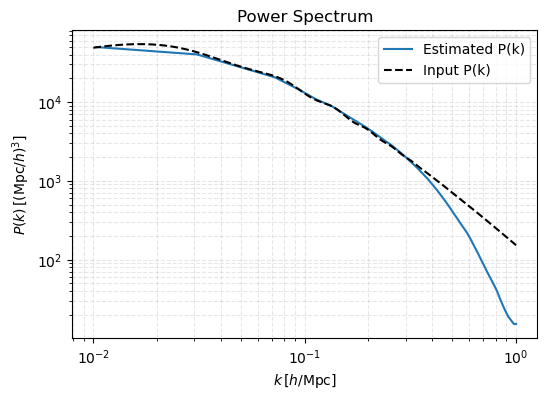

In [21]:
# Compute bin centers
k_mid = 0.5 * (k_bins[1:] + k_bins[:-1])

# Plot log-log power spectrum
plt.figure(figsize=(6,4))
plt.loglog(k_mid, Pk, label='Estimated P(k)')

# Compare to real P(k) from nbodykit
real = np.loadtxt("power_spectrum.txt", skiprows=1)
k_theory = real[:, 0]
P_theory = real[:, 1]

plt.loglog(k_theory, P_theory, color='k', linestyle='--', label='Input P(k)')

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [( \mathrm{Mpc}/h)^3 ]$')
plt.title('Power Spectrum')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.show()